In [1]:
!pip install transformers==4.36.2
!pip install --upgrade diffusers[torch]==0.25.1
!pip install accelerate==0.25.0
# # !pip install xformers==0.0.23.post1

  Obtaining dependency information for transformers==4.36.2 from https://files.pythonhosted.org/packages/20/0a/739426a81f7635b422fbe6cb8d1d99d1235579a6ac8024c13d743efa6847/transformers-4.36.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 27.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
  Obtaining dependency information for diffusers[torch]==0.25.1 from https://files.pythonhosted.org/packages/e4/c6/1f9768606c937e71c4d391307f395942c42d5567f538712dbf37b0cc0917/diffusers-0.25.1-py3-none-any.whl.metadata
  Obtaining dependency information for huggingface-hub>=0.20.2 from https://files.pythonhosted.org/packages/05/c0/779afbad8e75565c09ffa24a88b5dd7e293c92b74eb09df6435fc58ac986/huggingface_hub-0.22.2-py3-none-

In [2]:
offset = 0
last_image_index =None #None if don't know the number of images
QF = 25 
file_path = '/kaggle/input/imagedescription/Image_description.txt'

In [3]:
%load_ext autoreload
%autoreload 2
from diffusers import AutoencoderKL
from diffusers import UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer

import os
from PIL import Image, ImageOps
import requests
import torch
import matplotlib.pyplot as plt
import numpy as np
import PIL
import gc
import json
import time
import torch
import requests
from tqdm import tqdm
from io import BytesIO
from diffusers import StableDiffusionImg2ImgPipeline
import torchvision.transforms as T
from typing import Union, List, Optional, Callable

to_pil = T.ToPILImage()

from diffusers import AutoencoderKL
from diffusers import UNet2DConditionModel

from transformers import CLIPTextModel, CLIPTokenizer
import requests
from io import BytesIO

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def init_seeds(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  os.environ['PYTORCH_CUDA_ALLOC_CONF']='max_split_size_mb:224'

totensor = T.ToTensor()
topil = T.ToPILImage()

hyperparams = {
    'SEED' : 9222,
    'STRENGTH' : 0.7,
    'GUIDANCE_SCALE' : 7.5,
    'STEP_SIZE' : 0.02,
    'ITERS' : 1,
    'CLAMP_MIN' : -1,
    'CLAMP_MAX' : 1,
    'EPSILON': 0.06,
    "NUM_DENOISING_STEPS_FINAL": 50,
}

init_seeds(hyperparams['SEED'])

In [5]:
def recover_image(image, init_image, mask, background=False):
    image = totensor(image)
    mask = totensor(mask)
    init_image = totensor(init_image)
    if background:
        result = mask * init_image + (1 - mask) * image
    else:
        result = mask * image + (1 - mask) * init_image
    return topil(result)

def preprocess(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.0 * image - 1.0

def prepare_image(image):
    image = np.array(image.convert("RGB"))
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image).to(dtype=torch.float32) / 127.5 - 1.0

    return image[0]

In [6]:
preprocess_res = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

preprocess_tensor = T.Compose([
    T.ToTensor(),
])

preprocess_tensor_pil= T.ToPILImage()

In [7]:
def download_image(url):
    try:
        response = requests.get(url)
        init_image = Image.open(BytesIO(response.content)).convert("RGB")
        resize = T.transforms.Resize(512)
        center_crop = T.transforms.CenterCrop(512)
        init_image = center_crop(resize(init_image))

        return init_image
    except (requests.exceptions.RequestException, PIL.UnidentifiedImageError) as e:
    # Handle the exception here
        print(f"Error downloading/processing image: {e}")
    # You can return None, a default image, or log the error
        return None  # Example: return None if download fails

def read_image_prompt(file_path):
    with open(file_path, 'r') as file:
        text = file.read()
    sentences = text.split('\n')
    image_url = []
    prompt = []
    image_description = []
    for i, sentence in enumerate(sentences):
        if i%3==0:
            image_url.append(sentence)
        elif i%3==1:
            prompt.append(sentence)
        elif i%3==2:
            image_description.append(sentence)
            

    return (image_url, prompt, image_description)


image_url, prompt, _ = read_image_prompt(file_path)
image_url = image_url[:-1]

#take only some images  #-------------------------------------------------------------->>>>>>>>>>>>updates here
if last_image_index == None:
    image_url = image_url[offset:]
    prompt = prompt[offset:]
    
else:
    image_url = image_url[offset:last_image_index]
    prompt = prompt[offset:last_image_index]


In [8]:
# make sure you're logged in with `huggingface-cli login` - check https://github.com/huggingface/diffusers for more details
to_pil = T.ToPILImage()
model_id_or_path = "runwayml/stable-diffusion-v1-5"
# model_id_or_path = "CompVis/stable-diffusion-v1-4"
# model_id_or_path = "CompVis/stable-diffusion-v1-3"
# model_id_or_path = "CompVis/stable-diffusion-v1-2"
# model_id_or_path = "CompVis/stable-diffusion-v1-1"
os.environ['HF_HUB_OFFLINE']='True'

pipe_img2img = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_id_or_path,
    revision="fp16",
    safety_checker=None,
    torch_dtype=torch.float16,
    cache_dir = "/content/drive/MyDrive/MajorProject/Diffusers_cache_test/"
)
pipe_img2img = pipe_img2img.to("cuda")

model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/diffusers/pipelines/pipeline_utils.py:269: FutureWarning: You are loading the variant fp16 from runwayml/stable-diffusion-v1-5 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
vae/diffusion_pytorch_model.safetensors not found


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/307 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

text_encoder/pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/822 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [9]:
def gen_image(init_image, adv_image, path_to_save, prompt,  QF:int = 60):

    (height, width) = (512, 512)
    with torch.no_grad():

        adv_image.save(f'{path_to_save}/adv_image.png')
        init_image.save(f'{path_to_save}/original_image.png')
        num_compressions = (95-QF)//10
        jump = 10

        fig, ax = plt.subplots(nrows=2, ncols=num_compressions+2, figsize=(20,6))
        ax[0,0].imshow(init_image)
        ax[0,1].imshow(adv_image)
        # Play with these for improving generated image quality
        # SEED = np.random.randint(low=0, high=10000)

        STRENGTH = hyperparams['STRENGTH']
        GUIDANCE = hyperparams['GUIDANCE_SCALE']
        NUM_STEPS = hyperparams['NUM_DENOISING_STEPS_FINAL']
        SEED  = hyperparams['SEED']
        with torch.autocast('cuda'):
            torch.manual_seed(SEED)
            image_nat = pipe_img2img(prompt=prompt, image=init_image, strength=STRENGTH, guidance_scale=GUIDANCE, num_inference_steps=NUM_STEPS).images[0]
            torch.manual_seed(SEED)
            image_adv = pipe_img2img(prompt=prompt, image=adv_image, strength=STRENGTH, guidance_scale=GUIDANCE, num_inference_steps=NUM_STEPS).images[0]

        image_nat.save(f'{path_to_save}/gen_original_image.png')
        image_adv.save(f'{path_to_save}/gen_adversarial.png')
        ax[1,0].imshow(image_nat)
        ax[1,1].imshow(image_adv)
        ax[0,0].set_title('Source', fontsize=16)
        ax[0,1].set_title('Adv.', fontsize=16)

        for i in range(num_compressions):

            jpeg = DiffJPEG(height=height, width=width, differentiable=True).to('cuda')
            compressed_img = jpeg(preprocess_tensor(adv_image).unsqueeze(0).to('cuda') , quality=QF)

            preprocess_tensor_pil(compressed_img[0]).save(f"{path_to_save}/adv_image_compress_{QF}.png")
            jpg_image = Image.open(f"{path_to_save}/adv_image_compress_{QF}.png")
            with torch.autocast('cuda'):
                torch.manual_seed(SEED)
                image_adv_jpeg = pipe_img2img(prompt=prompt, image=jpg_image, strength=STRENGTH, guidance_scale=GUIDANCE, num_inference_steps=NUM_STEPS).images[0]
                image_adv_jpeg.save(f'{path_to_save}/gen_adv_image{QF}.png')

                ax[0,i+2].imshow(jpg_image)
                ax[1,i+2].imshow(image_adv_jpeg)
                ax[0,i+2].set_title(f'QF: {QF}.', fontsize=16)
            QF = QF + jump


        for i in range(2):
            for j in range(num_compressions+2):
                ax[i][j].grid(False)
                ax[i][j].axis('off')

        fig.suptitle(f"Prompt: {prompt}", fontsize=20)
        fig.tight_layout()
#         plt.show(plt.savefig(f"{path_to_save}/Result.png", bbox_inches='tight'))
        plt.savefig(f"{path_to_save}/Result.png", bbox_inches='tight')

        
def save_dict_to_text_file(dictionary, file_path, total_time, loss):
    """
    Convert a dictionary to a JSON-formatted string and save it to a text file.

    Parameters:
    - dictionary: The dictionary to be saved.
    - file_path: The target location and filename for the text file.
    """
    try:
        with open(f'{file_path}/config.txt', 'w') as file:
            json.dump(dictionary, file, indent=4)
            file.write(f'total time: {total_time}')
            for i, val in enumerate(loss):
                file.write(f'Loss Sample {i}: {val}')

        print(f"Dictionary successfully saved to {file_path}")
    except Exception as e:
        print(f"Error saving dictionary to {file_path}: {e}")
    
    


In [10]:
def pgd(X, model, eps=0.1, step_size=0.015, iters=40, clamp_min=0, clamp_max=1, mask=None):
    X_adv = X.clone().detach() + (torch.rand(*X.shape)*2*eps-eps).cuda()
    # then collect the garbage
    # gc.collect()

    pbar = tqdm(range(iters))
    for i in pbar:
        actual_step_size = step_size - (step_size - step_size / 100) / iters * i

        grad_sum = torch.zeros(X_adv.size()).to('cuda')

        QFs = [25, 50, 75, 100]
        for QF in QFs:

            X_adv.requires_grad_(True)
            loss = (model(X_adv, QF).latent_dist.mean).norm()

            grad, = torch.autograd.grad(loss, [X_adv])

            grad = grad.detach()
            X_adv = X_adv.detach()

            grad_sum += grad
            del grad
            torch.cuda.empty_cache()
        
            
        pbar.set_description(f"[Running attack]: Loss {loss.item():.5f} | step size: {actual_step_size:.4}")
        grads = grad_sum / len(QFs)

        X_adv = X_adv - grads.sign() * actual_step_size
        
        del grad_sum
        del grads
        torch.cuda.empty_cache()
        
        X_adv = torch.minimum(torch.maximum(X_adv, X - eps), X + eps)
        X_adv.data = torch.clamp(X_adv, min=clamp_min, max=clamp_max)
        # X_adv.grad = None

    return X_adv, loss

In [11]:
class CombinedModel(torch.nn.Module):
    def __init__(self, jpeg_model, diff_model):
        super(CombinedModel, self).__init__()
        self.jpeg_model = jpeg_model
        self.diff_model = diff_model

    def forward(self, x, QF:int):
        x = x.float()
        jpeg_output = self.jpeg_model(x, QF)
        jpeg_output = jpeg_output.half()
        diff_output = self.diff_model(jpeg_output)
        # combined_output = torch.cat((jpeg_output, resnet_output), dim=1)  # Concatenate along channels
        return diff_output

In [12]:
# We didn't write this ourselves but I don't remember from where we took this will find it's source and update

# Standard libraries
import itertools
import numpy as np
# PyTorch
import torch
import torch.nn as nn

y_table = np.array(
    [[16, 11, 10, 16, 24, 40, 51, 61], [12, 12, 14, 19, 26, 58, 60,
                                        55], [14, 13, 16, 24, 40, 57, 69, 56],
     [14, 17, 22, 29, 51, 87, 80, 62], [18, 22, 37, 56, 68, 109, 103,
                                        77], [24, 35, 55, 64, 81, 104, 113, 92],
     [49, 64, 78, 87, 103, 121, 120, 101], [72, 92, 95, 98, 112, 100, 103, 99]],
    dtype=np.float32).T

y_table = nn.Parameter(torch.from_numpy(y_table))
#
c_table = np.empty((8, 8), dtype=np.float32)
c_table.fill(99)
c_table[:4, :4] = np.array([[17, 18, 24, 47], [18, 21, 26, 66],
                            [24, 26, 56, 99], [47, 66, 99, 99]]).T
c_table = nn.Parameter(torch.from_numpy(c_table))


def diff_round(x):
    """ Differentiable rounding function
    Input:
        x(tensor)
    Output:
        x(tensor)
    """
    return torch.round(x) + (x - torch.round(x))**3


def quality_to_factor(quality):
    """ Calculate factor corresponding to quality
    Input:
        quality(float): Quality for jpeg compression
    Output:
        factor(float): Compression factor
    """
    if quality < 50:
        quality = 5000. / quality
    else:
        quality = 200. - quality*2
    return quality / 100.


class y_dequantize(nn.Module):
    """ Dequantize Y channel
    Inputs:
        image(tensor): batch x height x width
        factor(float): compression factor
    Outputs:
        image(tensor): batch x height x width

    """
    def __init__(self):
        super(y_dequantize, self).__init__()
        self.y_table = y_table

    def forward(self, image, factor):
        return image * (self.y_table * factor)


class c_dequantize(nn.Module):
    """ Dequantize CbCr channel
    Inputs:
        image(tensor): batch x height x width
        factor(float): compression factor
    Outputs:
        image(tensor): batch x height x width

    """
    def __init__(self):
        super(c_dequantize, self).__init__()
        self.c_table = c_table

    def forward(self, image , factor):
        return image * (self.c_table * factor)


class idct_8x8(nn.Module):
    """ Inverse discrete Cosine Transformation
    Input:
        dcp(tensor): batch x height x width
    Output:
        image(tensor): batch x height x width
    """
    def __init__(self):
        super(idct_8x8, self).__init__()
        alpha = np.array([1. / np.sqrt(2)] + [1] * 7)
        self.alpha = nn.Parameter(torch.from_numpy(np.outer(alpha, alpha)).float())
        tensor = np.zeros((8, 8, 8, 8), dtype=np.float32)
        for x, y, u, v in itertools.product(range(8), repeat=4):
            tensor[x, y, u, v] = np.cos((2 * u + 1) * x * np.pi / 16) * np.cos(
                (2 * v + 1) * y * np.pi / 16)
        self.tensor = nn.Parameter(torch.from_numpy(tensor).float())

    def forward(self, image):

        image = image * self.alpha
        result = 0.25 * torch.tensordot(image, self.tensor, dims=2) + 128
        result.view(image.shape)
        return result


class block_merging(nn.Module):
    """ Merge pathces into image
    Inputs:
        patches(tensor) batch x height*width/64, height x width
        height(int)
        width(int)
    Output:
        image(tensor): batch x height x width
    """
    def __init__(self):
        super(block_merging, self).__init__()

    def forward(self, patches, height, width):
        k = 8
        batch_size = patches.shape[0]
        image_reshaped = patches.view(batch_size, height//k, width//k, k, k)
        image_transposed = image_reshaped.permute(0, 1, 3, 2, 4)
        return image_transposed.contiguous().view(batch_size, height, width)


class chroma_upsampling(nn.Module):
    """ Upsample chroma layers
    Input:
        y(tensor): y channel image
        cb(tensor): cb channel
        cr(tensor): cr channel
    Ouput:
        image(tensor): batch x height x width x 3
    """
    def __init__(self):
        super(chroma_upsampling, self).__init__()

    def forward(self, y, cb, cr):
        def repeat(x, k=2):
            height, width = x.shape[1:3]
            x = x.unsqueeze(-1)
            x = x.repeat(1, 1, k, k)
            x = x.view(-1, height * k, width * k)
            return x

        cb = repeat(cb)
        cr = repeat(cr)

        return torch.cat([y.unsqueeze(3), cb.unsqueeze(3), cr.unsqueeze(3)], dim=3)


class ycbcr_to_rgb_jpeg(nn.Module):
    """ Converts YCbCr image to RGB JPEG
    Input:
        image(tensor): batch x height x width x 3
    Outpput:
        result(tensor): batch x 3 x height x width
    """
    def __init__(self):
        super(ycbcr_to_rgb_jpeg, self).__init__()

        matrix = np.array(
            [[1., 0., 1.402], [1, -0.344136, -0.714136], [1, 1.772, 0]],
            dtype=np.float32).T
        self.shift = nn.Parameter(torch.tensor([0, -128., -128.]))
        self.matrix = nn.Parameter(torch.from_numpy(matrix))

    def forward(self, image):
        result = torch.tensordot(image + self.shift, self.matrix, dims=1)
        #result = torch.from_numpy(result)
        result.view(image.shape)
        return result.permute(0, 3, 1, 2)


class decompress_jpeg(nn.Module):
    """ Full JPEG decompression algortihm
    Input:
        compressed(dict(tensor)): batch x h*w/64 x 8 x 8
        rounding(function): rounding function to use
        factor(float): Compression factor
    Ouput:
        image(tensor): batch x 3 x height x width
    """
    def __init__(self, height, width, rounding=torch.round):
        super(decompress_jpeg, self).__init__()
        self.c_dequantize = c_dequantize()
        self.y_dequantize = y_dequantize()
        self.idct = idct_8x8()
        self.merging = block_merging()
        self.chroma = chroma_upsampling()
        self.colors = ycbcr_to_rgb_jpeg()

        self.height, self.width = height, width

    def forward(self, y, cb, cr , factor):
        components = {'y': y, 'cb': cb, 'cr': cr}
        for k in components.keys():
            if k in ('cb', 'cr'):
                comp = self.c_dequantize(components[k], factor)
                height, width = int(self.height/2), int(self.width/2)
            else:
                comp = self.y_dequantize(components[k], factor)
                height, width = self.height, self.width
            comp = self.idct(comp)
            components[k] = self.merging(comp, height, width)
            #
        image = self.chroma(components['y'], components['cb'], components['cr'])
        image = self.colors(image)

        image = torch.min(255*torch.ones_like(image),
                          torch.max(torch.zeros_like(image), image))
        return image/255


# Standard libraries
import itertools
import numpy as np
# PyTorch
import torch
import torch.nn as nn


class rgb_to_ycbcr_jpeg(nn.Module):
    """ Converts RGB image to YCbCr
    Input:
        image(tensor): batch x 3 x height x width
    Outpput:
        result(tensor): batch x height x width x 3
    """
    def __init__(self):
        super(rgb_to_ycbcr_jpeg, self).__init__()
        matrix = np.array(
            [[0.299, 0.587, 0.114], [-0.168736, -0.331264, 0.5],
             [0.5, -0.418688, -0.081312]], dtype=np.float32).T
        self.shift = nn.Parameter(torch.tensor([0., 128., 128.]))
        #
        self.matrix = nn.Parameter(torch.from_numpy(matrix))

    def forward(self, image):
        image = image.permute(0, 2, 3, 1)
        result = torch.tensordot(image, self.matrix, dims=1) + self.shift
    #    result = torch.from_numpy(result)
        result.view(image.shape)
        return result



class chroma_subsampling(nn.Module):
    """ Chroma subsampling on CbCv channels
    Input:
        image(tensor): batch x height x width x 3
    Output:
        y(tensor): batch x height x width
        cb(tensor): batch x height/2 x width/2
        cr(tensor): batch x height/2 x width/2
    """
    def __init__(self):
        super(chroma_subsampling, self).__init__()

    def forward(self, image):
        image_2 = image.permute(0, 3, 1, 2).clone()
        avg_pool = nn.AvgPool2d(kernel_size=2, stride=(2, 2),
                                count_include_pad=False)
        cb = avg_pool(image_2[:, 1, :, :].unsqueeze(1))
        cr = avg_pool(image_2[:, 2, :, :].unsqueeze(1))
        cb = cb.permute(0, 2, 3, 1)
        cr = cr.permute(0, 2, 3, 1)
        return image[:, :, :, 0], cb.squeeze(3), cr.squeeze(3)


class block_splitting(nn.Module):
    """ Splitting image into patches
    Input:
        image(tensor): batch x height x width
    Output:
        patch(tensor):  batch x h*w/64 x h x w
    """
    def __init__(self):
        super(block_splitting, self).__init__()
        self.k = 8

    def forward(self, image):
        height, width = image.shape[1:3]
        batch_size = image.shape[0]
        image_reshaped = image.view(batch_size, height // self.k, self.k, -1, self.k)
        image_transposed = image_reshaped.permute(0, 1, 3, 2, 4)
        return image_transposed.contiguous().view(batch_size, -1, self.k, self.k)


class dct_8x8(nn.Module):
    """ Discrete Cosine Transformation
    Input:
        image(tensor): batch x height x width
    Output:
        dcp(tensor): batch x height x width
    """
    def __init__(self):
        super(dct_8x8, self).__init__()
        tensor = np.zeros((8, 8, 8, 8), dtype=np.float32)
        for x, y, u, v in itertools.product(range(8), repeat=4):
            tensor[x, y, u, v] = np.cos((2 * x + 1) * u * np.pi / 16) * np.cos(
                (2 * y + 1) * v * np.pi / 16)
        alpha = np.array([1. / np.sqrt(2)] + [1] * 7)
        #
        self.tensor =  nn.Parameter(torch.from_numpy(tensor).float())
        self.scale = nn.Parameter(torch.from_numpy(np.outer(alpha, alpha) * 0.25).float() )

    def forward(self, image):
        image = image - 128
        result = self.scale * torch.tensordot(image, self.tensor, dims=2)
        result.view(image.shape)
        return result


class y_quantize(nn.Module):
    """ JPEG Quantization for Y channel
    Input:
        image(tensor): batch x height x width
        rounding(function): rounding function to use
        factor(float): Degree of compression
    Output:
        image(tensor): batch x height x width
    """
    def __init__(self, rounding):
        super(y_quantize, self).__init__()
        self.rounding = rounding
        self.y_table = y_table

    def forward(self, image, factor):
        image = image.float() / (self.y_table * factor)
        image = self.rounding(image)
        return image


class c_quantize(nn.Module):
    """ JPEG Quantization for CrCb channels
    Input:
        image(tensor): batch x height x width
        rounding(function): rounding function to use
        factor(float): Degree of compression
    Output:
        image(tensor): batch x height x width
    """
    def __init__(self, rounding):
        super(c_quantize, self).__init__()
        self.rounding = rounding
        self.c_table = c_table

    def forward(self, image, factor):
        image = image.float() / (self.c_table * factor)
        image = self.rounding(image)
        return image


class compress_jpeg(nn.Module):
    """ Full JPEG compression algortihm
    Input:
        imgs(tensor): batch x 3 x height x width
        rounding(function): rounding function to use
        factor(float): Compression factor
    Ouput:
        compressed(dict(tensor)): batch x h*w/64 x 8 x 8
    """
    def __init__(self, rounding=torch.round):
        super(compress_jpeg, self).__init__()
        self.l1 = nn.Sequential(
            rgb_to_ycbcr_jpeg(),
            chroma_subsampling()
        )
        self.l2 = nn.Sequential(
            block_splitting(),
            dct_8x8()
        )
        self.c_quantize = c_quantize(rounding=rounding)
        self.y_quantize = y_quantize(rounding=rounding)

    def forward(self, image, factor=1):
        y, cb, cr = self.l1(image*255)
        components = {'y': y, 'cb': cb, 'cr': cr}
        for k in components.keys():
            comp = self.l2(components[k])
            if k in ('cb', 'cr'):
                comp = self.c_quantize(comp, factor)
            else:
                comp = self.y_quantize(comp, factor)

            components[k] = comp

        return components['y'], components['cb'], components['cr']

class DiffJPEG(nn.Module):
    def __init__(self, height, width, differentiable=True):
        ''' Initialize the DiffJPEG layer
        Inputs:
            height(int): Original image hieght
            width(int): Original image width
            differentiable(bool): If true uses custom differentiable
                rounding function, if false uses standrard torch.round
            quality(float): Quality factor for jpeg compression scheme.
        '''
        super(DiffJPEG, self).__init__()
        if differentiable:
            rounding = diff_round
        else:
            rounding = torch.round
        self.compress = compress_jpeg(rounding=rounding)
        self.decompress = decompress_jpeg(height, width, rounding=rounding)

    def forward(self, x, quality=80):
        '''

        '''

        factor = quality_to_factor(quality)
        if factor == 0:
          return x

        y, cb, cr = self.compress(x, factor)
        recovered = self.decompress(y, cb, cr, factor)
        return recovered


    
# Standard libraries
import itertools
import numpy as np
# PyTorch
import torch
import torch.nn as nn

y_table = np.array(
    [[16, 11, 10, 16, 24, 40, 51, 61], [12, 12, 14, 19, 26, 58, 60,
                                        55], [14, 13, 16, 24, 40, 57, 69, 56],
     [14, 17, 22, 29, 51, 87, 80, 62], [18, 22, 37, 56, 68, 109, 103,
                                        77], [24, 35, 55, 64, 81, 104, 113, 92],
     [49, 64, 78, 87, 103, 121, 120, 101], [72, 92, 95, 98, 112, 100, 103, 99]],
    dtype=np.float32).T

y_table = nn.Parameter(torch.from_numpy(y_table))
#
c_table = np.empty((8, 8), dtype=np.float32)
c_table.fill(99)
c_table[:4, :4] = np.array([[17, 18, 24, 47], [18, 21, 26, 66],
                            [24, 26, 56, 99], [47, 66, 99, 99]]).T
c_table = nn.Parameter(torch.from_numpy(c_table))


def diff_round(x):
    """ Differentiable rounding function
    Input:
        x(tensor)
    Output:
        x(tensor)
    """
    return torch.round(x) + (x - torch.round(x))**3


def quality_to_factor(quality):
    """ Calculate factor corresponding to quality
    Input:
        quality(float): Quality for jpeg compression
    Output:
        factor(float): Compression factor
    """
    if quality < 50:
        quality = 5000. / quality
    else:
        quality = 200. - quality*2
    return quality / 100.


class y_dequantize(nn.Module):
    """ Dequantize Y channel
    Inputs:
        image(tensor): batch x height x width
        factor(float): compression factor
    Outputs:
        image(tensor): batch x height x width

    """
    def __init__(self):
        super(y_dequantize, self).__init__()
        self.y_table = y_table

    def forward(self, image, factor):
        return image * (self.y_table * factor)


class c_dequantize(nn.Module):
    """ Dequantize CbCr channel
    Inputs:
        image(tensor): batch x height x width
        factor(float): compression factor
    Outputs:
        image(tensor): batch x height x width

    """
    def __init__(self):
        super(c_dequantize, self).__init__()
        self.c_table = c_table

    def forward(self, image , factor):
        return image * (self.c_table * factor)


class idct_8x8(nn.Module):
    """ Inverse discrete Cosine Transformation
    Input:
        dcp(tensor): batch x height x width
    Output:
        image(tensor): batch x height x width
    """
    def __init__(self):
        super(idct_8x8, self).__init__()
        alpha = np.array([1. / np.sqrt(2)] + [1] * 7)
        self.alpha = nn.Parameter(torch.from_numpy(np.outer(alpha, alpha)).float())
        tensor = np.zeros((8, 8, 8, 8), dtype=np.float32)
        for x, y, u, v in itertools.product(range(8), repeat=4):
            tensor[x, y, u, v] = np.cos((2 * u + 1) * x * np.pi / 16) * np.cos(
                (2 * v + 1) * y * np.pi / 16)
        self.tensor = nn.Parameter(torch.from_numpy(tensor).float())

    def forward(self, image):

        image = image * self.alpha
        result = 0.25 * torch.tensordot(image, self.tensor, dims=2) + 128
        result.view(image.shape)
        return result


class block_merging(nn.Module):
    """ Merge pathces into image
    Inputs:
        patches(tensor) batch x height*width/64, height x width
        height(int)
        width(int)
    Output:
        image(tensor): batch x height x width
    """
    def __init__(self):
        super(block_merging, self).__init__()

    def forward(self, patches, height, width):
        k = 8
        batch_size = patches.shape[0]
        image_reshaped = patches.view(batch_size, height//k, width//k, k, k)
        image_transposed = image_reshaped.permute(0, 1, 3, 2, 4)
        return image_transposed.contiguous().view(batch_size, height, width)


class chroma_upsampling(nn.Module):
    """ Upsample chroma layers
    Input:
        y(tensor): y channel image
        cb(tensor): cb channel
        cr(tensor): cr channel
    Ouput:
        image(tensor): batch x height x width x 3
    """
    def __init__(self):
        super(chroma_upsampling, self).__init__()

    def forward(self, y, cb, cr):
        def repeat(x, k=2):
            height, width = x.shape[1:3]
            x = x.unsqueeze(-1)
            x = x.repeat(1, 1, k, k)
            x = x.view(-1, height * k, width * k)
            return x

        cb = repeat(cb)
        cr = repeat(cr)

        return torch.cat([y.unsqueeze(3), cb.unsqueeze(3), cr.unsqueeze(3)], dim=3)


class ycbcr_to_rgb_jpeg(nn.Module):
    """ Converts YCbCr image to RGB JPEG
    Input:
        image(tensor): batch x height x width x 3
    Outpput:
        result(tensor): batch x 3 x height x width
    """
    def __init__(self):
        super(ycbcr_to_rgb_jpeg, self).__init__()

        matrix = np.array(
            [[1., 0., 1.402], [1, -0.344136, -0.714136], [1, 1.772, 0]],
            dtype=np.float32).T
        self.shift = nn.Parameter(torch.tensor([0, -128., -128.]))
        self.matrix = nn.Parameter(torch.from_numpy(matrix))

    def forward(self, image):
        result = torch.tensordot(image + self.shift, self.matrix, dims=1)
        #result = torch.from_numpy(result)
        result.view(image.shape)
        return result.permute(0, 3, 1, 2)


class decompress_jpeg(nn.Module):
    """ Full JPEG decompression algortihm
    Input:
        compressed(dict(tensor)): batch x h*w/64 x 8 x 8
        rounding(function): rounding function to use
        factor(float): Compression factor
    Ouput:
        image(tensor): batch x 3 x height x width
    """
    def __init__(self, height, width, rounding=torch.round):
        super(decompress_jpeg, self).__init__()
        self.c_dequantize = c_dequantize()
        self.y_dequantize = y_dequantize()
        self.idct = idct_8x8()
        self.merging = block_merging()
        self.chroma = chroma_upsampling()
        self.colors = ycbcr_to_rgb_jpeg()

        self.height, self.width = height, width

    def forward(self, y, cb, cr , factor):
        components = {'y': y, 'cb': cb, 'cr': cr}
        for k in components.keys():
            if k in ('cb', 'cr'):
                comp = self.c_dequantize(components[k], factor)
                height, width = int(self.height/2), int(self.width/2)
            else:
                comp = self.y_dequantize(components[k], factor)
                height, width = self.height, self.width
            comp = self.idct(comp)
            components[k] = self.merging(comp, height, width)
            #
        image = self.chroma(components['y'], components['cb'], components['cr'])
        image = self.colors(image)

        image = torch.min(255*torch.ones_like(image),
                          torch.max(torch.zeros_like(image), image))
        return image/255


# Standard libraries
import itertools
import numpy as np
# PyTorch
import torch
import torch.nn as nn


class rgb_to_ycbcr_jpeg(nn.Module):
    """ Converts RGB image to YCbCr
    Input:
        image(tensor): batch x 3 x height x width
    Outpput:
        result(tensor): batch x height x width x 3
    """
    def __init__(self):
        super(rgb_to_ycbcr_jpeg, self).__init__()
        matrix = np.array(
            [[0.299, 0.587, 0.114], [-0.168736, -0.331264, 0.5],
             [0.5, -0.418688, -0.081312]], dtype=np.float32).T
        self.shift = nn.Parameter(torch.tensor([0., 128., 128.]))
        #
        self.matrix = nn.Parameter(torch.from_numpy(matrix))

    def forward(self, image):
        image = image.permute(0, 2, 3, 1)
        result = torch.tensordot(image, self.matrix, dims=1) + self.shift
    #    result = torch.from_numpy(result)
        result.view(image.shape)
        return result



class chroma_subsampling(nn.Module):
    """ Chroma subsampling on CbCv channels
    Input:
        image(tensor): batch x height x width x 3
    Output:
        y(tensor): batch x height x width
        cb(tensor): batch x height/2 x width/2
        cr(tensor): batch x height/2 x width/2
    """
    def __init__(self):
        super(chroma_subsampling, self).__init__()

    def forward(self, image):
        image_2 = image.permute(0, 3, 1, 2).clone()
        avg_pool = nn.AvgPool2d(kernel_size=2, stride=(2, 2),
                                count_include_pad=False)
        cb = avg_pool(image_2[:, 1, :, :].unsqueeze(1))
        cr = avg_pool(image_2[:, 2, :, :].unsqueeze(1))
        cb = cb.permute(0, 2, 3, 1)
        cr = cr.permute(0, 2, 3, 1)
        return image[:, :, :, 0], cb.squeeze(3), cr.squeeze(3)


class block_splitting(nn.Module):
    """ Splitting image into patches
    Input:
        image(tensor): batch x height x width
    Output:
        patch(tensor):  batch x h*w/64 x h x w
    """
    def __init__(self):
        super(block_splitting, self).__init__()
        self.k = 8

    def forward(self, image):
        height, width = image.shape[1:3]
        batch_size = image.shape[0]
        image_reshaped = image.view(batch_size, height // self.k, self.k, -1, self.k)
        image_transposed = image_reshaped.permute(0, 1, 3, 2, 4)
        return image_transposed.contiguous().view(batch_size, -1, self.k, self.k)


class dct_8x8(nn.Module):
    """ Discrete Cosine Transformation
    Input:
        image(tensor): batch x height x width
    Output:
        dcp(tensor): batch x height x width
    """
    def __init__(self):
        super(dct_8x8, self).__init__()
        tensor = np.zeros((8, 8, 8, 8), dtype=np.float32)
        for x, y, u, v in itertools.product(range(8), repeat=4):
            tensor[x, y, u, v] = np.cos((2 * x + 1) * u * np.pi / 16) * np.cos(
                (2 * y + 1) * v * np.pi / 16)
        alpha = np.array([1. / np.sqrt(2)] + [1] * 7)
        #
        self.tensor =  nn.Parameter(torch.from_numpy(tensor).float())
        self.scale = nn.Parameter(torch.from_numpy(np.outer(alpha, alpha) * 0.25).float() )

    def forward(self, image):
        image = image - 128
        result = self.scale * torch.tensordot(image, self.tensor, dims=2)
        result.view(image.shape)
        return result


class y_quantize(nn.Module):
    """ JPEG Quantization for Y channel
    Input:
        image(tensor): batch x height x width
        rounding(function): rounding function to use
        factor(float): Degree of compression
    Output:
        image(tensor): batch x height x width
    """
    def __init__(self, rounding):
        super(y_quantize, self).__init__()
        self.rounding = rounding
        self.y_table = y_table

    def forward(self, image, factor):
        image = image.float() / (self.y_table * factor)
        image = self.rounding(image)
        return image


class c_quantize(nn.Module):
    """ JPEG Quantization for CrCb channels
    Input:
        image(tensor): batch x height x width
        rounding(function): rounding function to use
        factor(float): Degree of compression
    Output:
        image(tensor): batch x height x width
    """
    def __init__(self, rounding):
        super(c_quantize, self).__init__()
        self.rounding = rounding
        self.c_table = c_table

    def forward(self, image, factor):
        image = image.float() / (self.c_table * factor)
        image = self.rounding(image)
        return image


class compress_jpeg(nn.Module):
    """ Full JPEG compression algortihm
    Input:
        imgs(tensor): batch x 3 x height x width
        rounding(function): rounding function to use
        factor(float): Compression factor
    Ouput:
        compressed(dict(tensor)): batch x h*w/64 x 8 x 8
    """
    def __init__(self, rounding=torch.round):
        super(compress_jpeg, self).__init__()
        self.l1 = nn.Sequential(
            rgb_to_ycbcr_jpeg(),
            chroma_subsampling()
        )
        self.l2 = nn.Sequential(
            block_splitting(),
            dct_8x8()
        )
        self.c_quantize = c_quantize(rounding=rounding)
        self.y_quantize = y_quantize(rounding=rounding)

    def forward(self, image, factor=1):
        y, cb, cr = self.l1(image*255)
        components = {'y': y, 'cb': cb, 'cr': cr}
        for k in components.keys():
            comp = self.l2(components[k])
            if k in ('cb', 'cr'):
                comp = self.c_quantize(comp, factor)
            else:
                comp = self.y_quantize(comp, factor)

            components[k] = comp

        return components['y'], components['cb'], components['cr']

class DiffJPEG(nn.Module):
    def __init__(self, height, width, differentiable=True):
        ''' Initialize the DiffJPEG layer
        Inputs:
            height(int): Original image hieght
            width(int): Original image width
            differentiable(bool): If true uses custom differentiable
                rounding function, if false uses standrard torch.round
            quality(float): Quality factor for jpeg compression scheme.
        '''
        super(DiffJPEG, self).__init__()
        if differentiable:
            rounding = diff_round
        else:
            rounding = torch.round
        self.compress = compress_jpeg(rounding=rounding)
        self.decompress = decompress_jpeg(height, width, rounding=rounding)

    def forward(self, x, quality=80):
        '''

        '''

        factor = quality_to_factor(quality)
        if factor == 0:
          return x

        y, cb, cr = self.compress(x, factor)
        recovered = self.decompress(y, cb, cr, factor)
        return recovered

In [13]:
def free_memory(model):
    for p in model.parameters():
        if p.grad is not None:
            del p.grad  # free some memory
    del model
    torch.cuda.empty_cache()

def init_model():
  diffModel = pipe_img2img.vae.encode
  height, width = (512,512)  #HardCoded
  jpeg = DiffJPEG(height=height, width=width, differentiable=True)  #Change
  model = CombinedModel(jpeg, diffModel).to("cuda")
  return model

model  = init_model()

In [14]:
SEED = hyperparams['SEED']
num_images = len(image_url)
image_tensor = torch.zeros((num_images,3,512,512)).half()
loss = []
GUIDANCE = hyperparams['GUIDANCE_SCALE']
STRENGTH = hyperparams["STRENGTH"]
ITERATION = hyperparams["ITERS"]
EPSILON = hyperparams["EPSILON"]
STEP_SIZE = hyperparams["STEP_SIZE"]


#Save individual image tensors
save_image_tensor = f'/kaggle/working/ImageTensor'
if not os.path.exists(save_image_tensor):
    os.mkdir(save_image_tensor)

height, width = (512,512)  #HardCoded

for i in range(num_images):
    with torch.autocast('cuda'):
        init_seeds(SEED)
        init_image = download_image(image_url[i])
        if init_image == None:
            continue
        X = preprocess(init_image).half().to("cuda")
        start = time.time()
        result, loss_sample = pgd(X,
                model = model,
                clamp_min=-1,
                clamp_max=1,
                eps=EPSILON, # The higher, the less imperceptible the attack is
                step_size=STEP_SIZE, # Set smaller than eps
                iters=ITERATION, # The higher, the stronger your attack will be
              )

        torch.save(result.cpu(), f"{save_image_tensor}/{i+offset}_encoder_result_image.pt")
        total_time = time.time() - start
        image_tensor[i, :, :, :] = result.cpu()
        loss.append(loss_sample)
    
        del result, X
        torch.cuda.empty_cache()
        gc.collect()


[Running attack]: Loss 664.58344 | step size: 0.02: 100%|██████████| 1/1 [00:04<00:00,  4.24s/it]
[Running attack]: Loss 608.05402 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]
[Running attack]: Loss 660.09491 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


Error downloading/processing image: cannot identify image file <_io.BytesIO object at 0x795a04d574c0>


[Running attack]: Loss 665.57837 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]
[Running attack]: Loss 490.14401 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]
[Running attack]: Loss 628.09515 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]
[Running attack]: Loss 578.32098 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]
[Running attack]: Loss 575.66101 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]
[Running attack]: Loss 623.71954 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]
[Running attack]: Loss 638.69025 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]
[Running attack]: Loss 700.03662 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]
[Running attack]: Loss 456.26624 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]
[Running attack]: Loss 527.08850 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]
[Running attack]: Lo

Error downloading/processing image: cannot identify image file <_io.BytesIO object at 0x795a0c5fa930>


[Running attack]: Loss 657.25311 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]
[Running attack]: Loss 598.42535 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]
[Running attack]: Loss 593.81128 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]
[Running attack]: Loss 568.36145 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]
[Running attack]: Loss 712.15894 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]
[Running attack]: Loss 660.44666 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]
[Running attack]: Loss 485.51205 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]
[Running attack]: Loss 626.04803 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]
[Running attack]: Loss 576.26184 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it]
[Running attack]: Loss 655.75726 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it]
[Running attack]: Lo

Error downloading/processing image: HTTPConnectionPool(host='www.wall001.com', port=80): Max retries exceeded with url: /paint/Bob_Ross_CSG/mxxx01/bob_ross_csg017_winter_stillness.jpg (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x795a0cc6f9d0>, 'Connection to www.wall001.com timed out. (connect timeout=None)'))


[Running attack]: Loss 608.18756 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]
[Running attack]: Loss 582.07446 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]
[Running attack]: Loss 450.61713 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]
[Running attack]: Loss 509.45139 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]
[Running attack]: Loss 480.87372 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]
[Running attack]: Loss 479.03073 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it]
[Running attack]: Loss 414.39270 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]
[Running attack]: Loss 638.19922 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


Error downloading/processing image: cannot identify image file <_io.BytesIO object at 0x795a060c2b60>


[Running attack]: Loss 417.25854 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]
[Running attack]: Loss 618.03864 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]
[Running attack]: Loss 517.90570 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]
[Running attack]: Loss 564.85925 | step size: 0.02: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Dictionary successfully saved to /kaggle/working/0/


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Dictionary successfully saved to /kaggle/working/1/


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Dictionary successfully saved to /kaggle/working/2/
Error downloading/processing image: cannot identify image file <_io.BytesIO object at 0x795a04cb8a40>


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Dictionary successfully saved to /kaggle/working/4/


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

KeyboardInterrupt: 

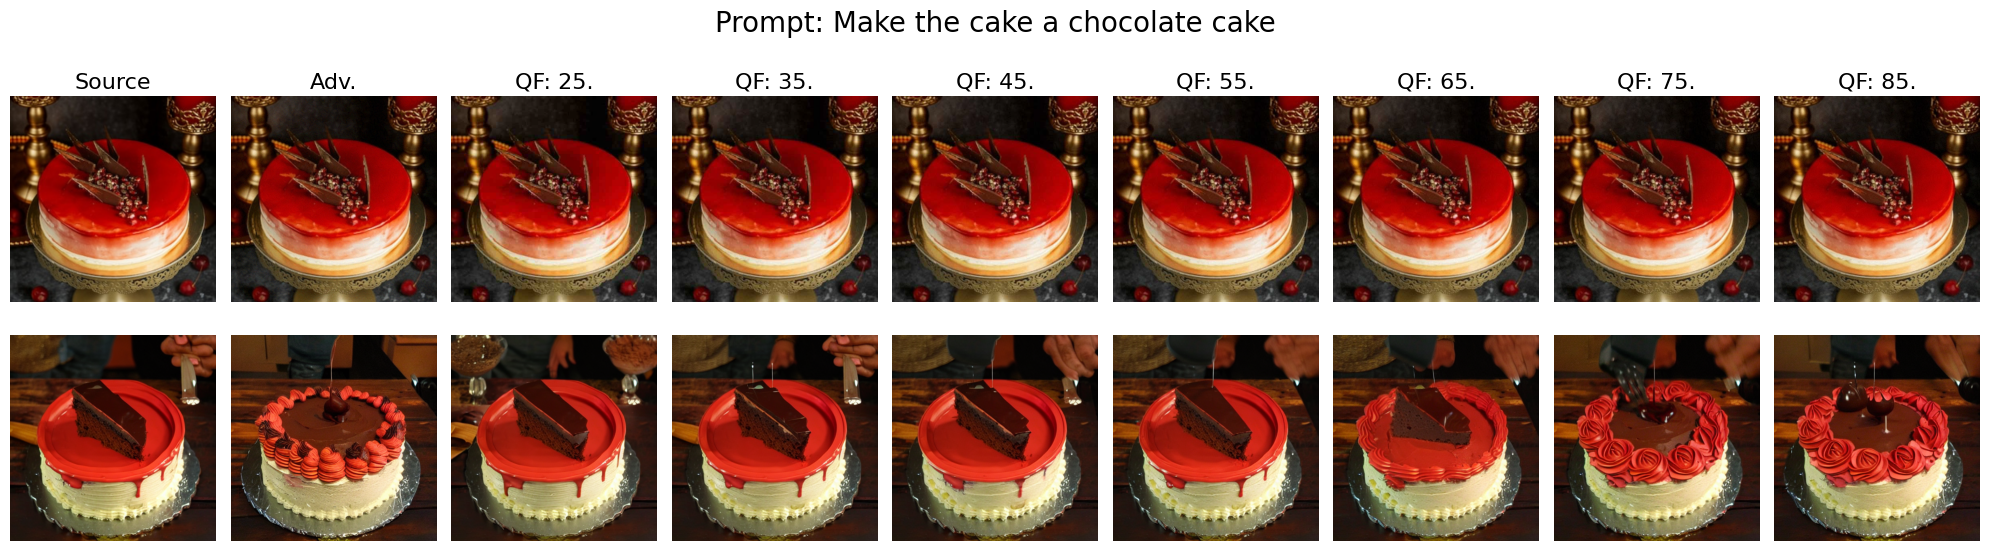

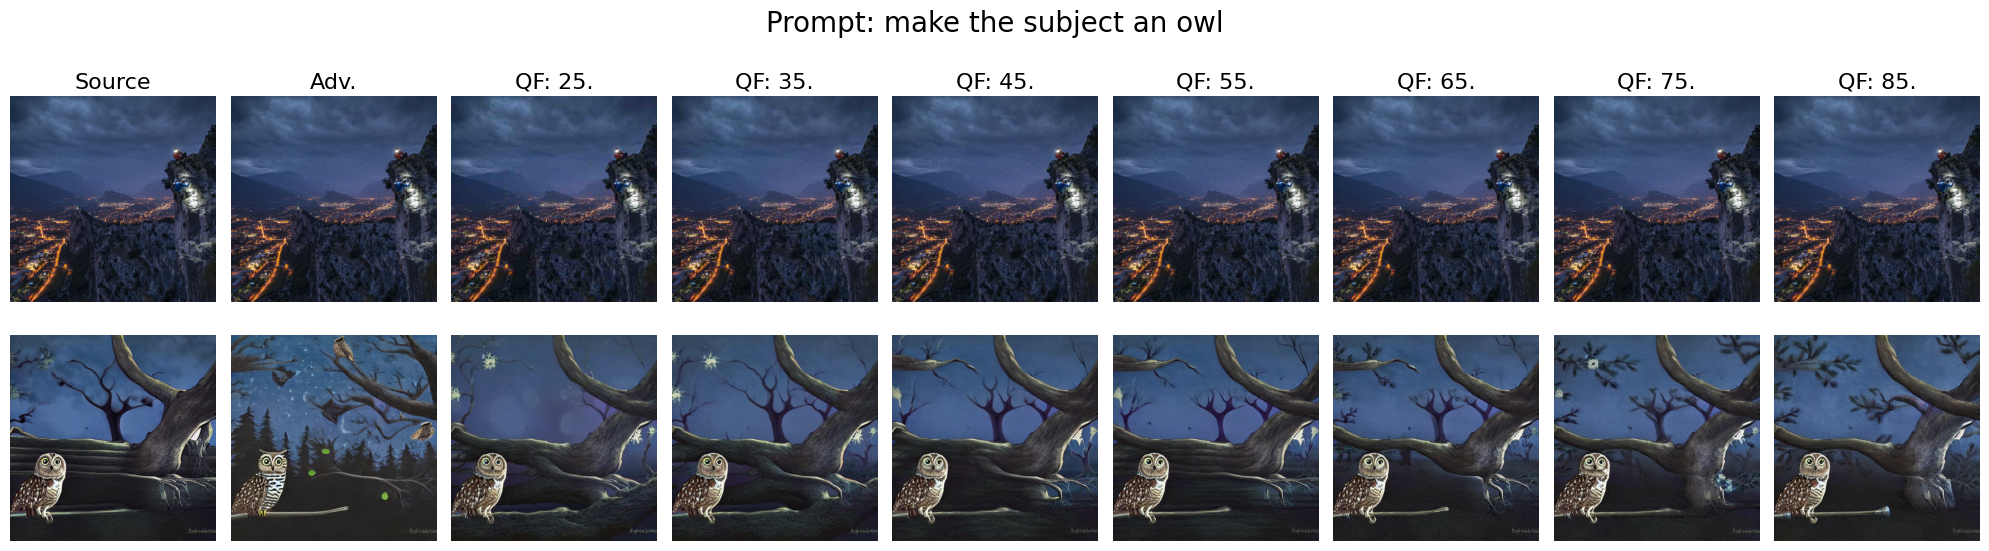

In [ ]:
import json
for i in range(num_images):
    result = image_tensor[i].unsqueeze(0).cuda()
    adv_X = (result / 2 + 0.5).clamp(0, 1)    
    adv_image = to_pil(adv_X[0]).convert("RGB")
    num_inference_steps = hyperparams['NUM_DENOISING_STEPS_FINAL']
    prompt_image = prompt[i]
    torch.cuda.empty_cache()
    
    path_to_save = f'/kaggle/working/{i+offset}/'
    if not os.path.exists(path_to_save):
        os.mkdir(path_to_save)
    
    init_image = download_image(image_url[i])
    if init_image == None:
        continue
    gen_image(init_image, adv_image, path_to_save, prompt_image, QF)
    save_dict_to_text_file( hyperparams, path_to_save, total_time, loss)


In [ ]:
!zip -r fileensembleencoder500.zip /kaggle/working
# from IPython.display import FileLink
# FileLink(r'/kaggle/working/file.zip')
from IPython.display import FileLink
FileLink(r'fileensembleencoder500.zip')
